# Comenzando con lenstronomy ... 


### Perfiles luminosos, datos y otros

Esta clase esta basada en la starting guide de lenstronomy creada por Simon Birrer y disponible en:

https://github.com/sibirrer/lenstronomy_extensions/blob/master/lenstronomy_extensions/Notebooks/starting_guide.ipynb

Los objetivos de esta clase son:

1. Conocer el modulo LightModel para describir perfiles luminosos de las lentes y fuentes
2. Conocer el modulo PointSource
3. Conocer el modulo Data para definir los datos a simular/ajustar
4. Simular la imagen de un sistema lente

In [1]:
# some standard python imports #
import numpy as np
import copy
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
def gradtorad(x):
    return x*np.pi/180


## LightModel module

Este modulo permite describir el brillo superficial de una galaxia. 

Este modulo admite varios perfiles analíticos, así como tambien shapelet. https://lenstronomy.readthedocs.io/en/latest/lenstronomy.LightModel.html

Mas informacion sobre que son las shapelets: Refregier (2003) https://arxiv.org/pdf/astro-ph/0105178.pdf

Se permite cualquier superposición de diferentes perfiles.

El parametros 'amp' es la amplitud a la mitad del radio de luz (half light radius). Este parametro nivela la amplitud del brillo superficial de un determinado perfil. 
**Las unidades no se especifican**  solo reflejan efectivamente una cantidad del brillo superficial integrado sobre la unidad del ángulo cuadrado.

En el módulo **𝚂𝚒𝚖𝚞𝚕𝚊𝚝𝚒𝚘𝚗𝙰𝙿𝙸**, se puede elegir convenientemente magnitudes astronómicas como entradas a los perfiles, siempre que se declare el punto cero de la magnitud.
https://lenstronomy.readthedocs.io/en/latest/lenstronomy.SimulationAPI.html

In [3]:
# importamos la clase LightModel #
from lenstronomy.LightModel.light_model import LightModel

# preparamos la lista de perfiles luminosos a usar
source_light_model_list = ['SERSIC']
lightModel_source = LightModel(light_model_list=source_light_model_list)

lens_light_model_list = ['SERSIC_ELLIPSE']
lightModel_lens = LightModel(light_model_list=lens_light_model_list)


# definimos los parametros #
#amp es la amplitud al la mitad del radio de luz (half light radius)
beta_ra,beta_dec = 0.001,0.1
kwargs_light_source = [{'amp': 100, 'R_sersic': 0.1, 'n_sersic': 1.5, 'center_x': beta_ra, 'center_y': beta_dec}]

import lenstronomy.Util.param_util as param_util
e1, e2 = param_util.phi_q2_ellipticity(phi=0.5, q=0.7)
kwargs_light_lens = [{'amp': 1000, 'R_sersic': 0.1, 'n_sersic': 2.5, 'e1': e1, 'e2': e2, 'center_x': 0.1, 'center_y': 0}]

# Evalua el brillo superficial a una posicion especifica
flux = lightModel_lens.surface_brightness(x=1, y=1, kwargs_list=kwargs_light_lens)
flux

array(0.14634866)

## PointSource Module

Para predecir y modelar con precisión la posición y el flujo de fuentes puntuales, se deben aplicar procedimientos numéricos diferentes que a las fuentes de extendidas. 

La clase 𝙿𝚘𝚒𝚗𝚝𝚂𝚘𝚞𝚛𝚌𝚎 gestiona las diferentes opciones para describir fuentes puntuales (por ejemplo, en el plano de la imagen o el plano de la fuente) y proporciona una interfaz homogénea para acceder a las posiciones y aumentos de la imagen.

https://lenstronomy.readthedocs.io/en/latest/lenstronomy.PointSource.html

In [4]:
from lenstronomy.LensModel.lens_model import LensModel
lens_model_list = ['SPEP']
lensModel = LensModel(lens_model_list=lens_model_list)
kwargs_spep = {'theta_E': 1.1, 'e1': 0.05, 'e2': 0.05, 'gamma': 2., 'center_x': 0.1, 'center_y': 0}
kwargs_lens = [kwargs_spep]

### utilizando la posicion de la fuente beta_ra y beta_dec:

In [5]:
# importamos la clase PointSource #
from lenstronomy.PointSource.point_source import PointSource

# utilizando la posicion de la fuente #
point_source_model_list = ['SOURCE_POSITION']
pointSource = PointSource(point_source_type_list=point_source_model_list, lensModel=lensModel, fixed_magnification_list=[True])
#Si fixed_magnification=True, entonces usa ‘source_amp’, osea la amplitud de la fuente
#sino usa 'point_amp' que es la magnificacion de cada imagen de la fuente

kwargs_ps = [{'ra_source': beta_ra, 'dec_source': beta_dec, 'source_amp': 100}]

# La posiciones de las imagenes y sus amplitudes  #
x_pos, y_pos = pointSource.image_position(kwargs_ps=kwargs_ps, kwargs_lens=kwargs_lens)
point_amp = pointSource.image_amplitude(kwargs_ps=kwargs_ps, kwargs_lens=kwargs_lens)
print('posicion',x_pos, y_pos)
print('amplitudes',point_amp)

posicion [array([-0.55163417,  0.14995884, -0.53886524,  1.04856558])] [array([ 1.14145383, -1.0581732 , -0.82929822,  0.04604259])]
amplitudes [array([313.16216659, 809.99466456, 642.21731953, 280.93951161])]


### Utilizando la posicion de las imagenes de la fuente en el plano lente: 

In [6]:
# lensed image positions (solution of the lens equation) #
point_source_model_list = ['LENSED_POSITION']
pointSource = PointSource(point_source_type_list=point_source_model_list, lensModel=lensModel, fixed_magnification_list=[False])

from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
solver = LensEquationSolver(lensModel)
theta_ra, theta_dec = solver.image_position_from_source(beta_ra, beta_dec, kwargs_lens)
mag = lensModel.magnification(theta_ra, theta_dec, kwargs_lens)

kwargs_ps = [{'ra_image': theta_ra, 'dec_image': theta_dec, 'point_amp': np.abs(mag)*100}] #100 es la amplitud de la fuente

# return image positions and amplitudes #
x_pos, y_pos = pointSource.image_position(kwargs_ps=kwargs_ps, kwargs_lens=kwargs_lens)
point_amp = pointSource.image_amplitude(kwargs_ps=kwargs_ps, kwargs_lens=kwargs_lens)
print('posicion',x_pos, y_pos)
print('amplitudes',point_amp)

posicion [array([-0.55163417,  0.14995884, -0.53886524,  1.04856558])] [array([ 1.14145383, -1.0581732 , -0.82929822,  0.04604259])]
amplitudes [array([313.16216659, 809.99466456, 642.21731953, 280.93951161])]


## Data module

https://lenstronomy.readthedocs.io/en/latest/lenstronomy.Data.html

La clase **𝙿𝚒𝚡𝚎𝚕𝙶𝚛𝚒𝚍** almacena y gestiona el marco de coordenadas y la transformación de coordenadas a píxeles necesaria para **simular imágenes.**

In [7]:
# import la clase PixelGrid()#
from lenstronomy.Data.pixel_grid import PixelGrid

deltaPix = 0.05  # tamano del pixel en cordenadas angulares (arcsec)

# configurar los argumentos para crear la clase Data 
ra_at_xy_0, dec_at_xy_0 = -2.5, -2.5 # coordinate in angles (RA/DEC) at the position of the pixel edge (0,0)
transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix  # linear translation matrix of a shift in pixel in a shift in coordinates

kwargs_pixel = {'nx': 100, 'ny': 100,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 

pixel_grid = PixelGrid(**kwargs_pixel)

In [8]:
# da la lista de coordenadas de pixeles #
x_coords, y_coords = pixel_grid.pixel_coordinates

# da el pixel donde se encuentran las coordenadas ra y dec
x_pos, y_pos = pixel_grid.map_coord2pix(ra=0, dec=0)

# da las coordenadas ra y dec en el pixel x,y
ra_pos, dec_pos = pixel_grid.map_pix2coord(x=20, y=10)

#print(x_coords,y_coords)
print(x_pos,y_pos)
print(ra_pos,dec_pos)

50.0 50.0
-1.5 -2.0


La clase **𝙿𝚂𝙵** maneja la convolución de la PSF. Se pueden usar kernels de convolución pixelizados, así como perfiles analíticos.

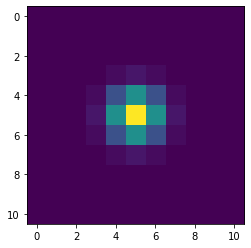

In [9]:
# importar la clase PSF
from lenstronomy.Data.psf import PSF

kwargs_psf = {'psf_type': 'GAUSSIAN',  # type of PSF model (supports 'GAUSSIAN' and 'PIXEL')
              'fwhm': 0.1,  # full width at half maximum of the Gaussian PSF (in angular units)
              'pixel_size': deltaPix  # angular scale of a pixel (required for a Gaussian PSF to translate the FWHM into a pixel scale)
             }
psf = PSF(**kwargs_psf)

# return the pixel kernel corresponding to a point source # 
kernel = psf.kernel_point_source
plt.imshow(kernel)

La clase **𝙳𝚊𝚝𝚊** hereda la 𝙿𝚒𝚡𝚎𝚕𝙶𝚛𝚒𝚍 y, además, administra cantidades específicas como valores de los píxeles y propiedades del ruido, que se requieren cuando se ajustan los modelos a los datos para estimar la probabilidad de los datos dado un modelo. 

## Nos falta simular la Imagen! 

## ImSim module

Este módulo simula imágenes. Esta es la interfaz para combinar todos los diferentes componentes, 𝙻𝚎𝚗𝚜𝙼𝚘𝚍𝚎𝚕, 𝙻𝚒𝚐𝚑𝚝𝙼𝚘𝚍𝚎𝚕, 𝙿𝚘𝚒𝚗𝚝𝚂𝚘𝚞𝚛𝚌𝚎 y 𝙳𝚊𝚝𝚊 para modelar imágenes. 

El 𝙻𝚒𝚐𝚑𝚝𝙼𝚘𝚍𝚎𝚕 se puede utilizar para modelar la luz de la lente y la fuente.

Simulamos una imagen usando el modulo 𝙸𝚖𝚊𝚐𝚎𝙼𝚘𝚍𝚎𝚕.

Podemos definir dos instancias 𝙻𝚒𝚐𝚑𝚝𝙼𝚘𝚍𝚎𝚕 diferentes para la luz de la lente y la fuente. 

Podemos definir la resolución del trazado de rayos y si la convolución de la PSF se aplica en la imagen con mayor resolución o no.

In [10]:
# definimos "numerics" 
# una instancia que nos permitira realizar computos con distintas configuraciones
# Cada configuracion dependera de lo que se quiere lograr.
# y tendra implicaciones tanto en el tiempo de computo como en la presicion del modelo
# Para mas detalles pueden revisar el notebook "lenstronomy_numerics" en las extensiones de lenstronomy

kwargs_numerics = {'supersampling_factor': 1, # each pixel gets super-sampled (in each axis direction) 
                  'supersampling_convolution': False}



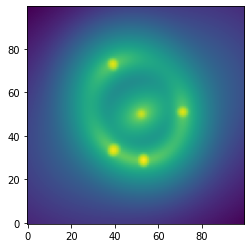

In [11]:
# importar la clase ImageModel
from lenstronomy.ImSim.image_model import ImageModel

# inicializar la clase ImageModel combinando los modulos que creamos antes 
imageModel = ImageModel(data_class=pixel_grid, 
                        psf_class=psf, 
                        lens_model_class=lensModel,
                        source_model_class=lightModel_source,
                        lens_light_model_class=lightModel_lens,
                        point_source_class= pointSource, 
                        kwargs_numerics=kwargs_numerics)


# simulamos la imagen con los paremetros definidos antes
image = imageModel.image(kwargs_lens=kwargs_lens,
                         kwargs_source=kwargs_light_source,
                         kwargs_lens_light=kwargs_light_lens, 
                         kwargs_ps=kwargs_ps)
plt.imshow(np.log10(image),origin='lower')


<ipython-input-12-7d71d95da2c1>:13: RuntimeWarning: invalid value encountered in log10
  axes[1].matshow(np.log10(image_noisy), origin='lower')


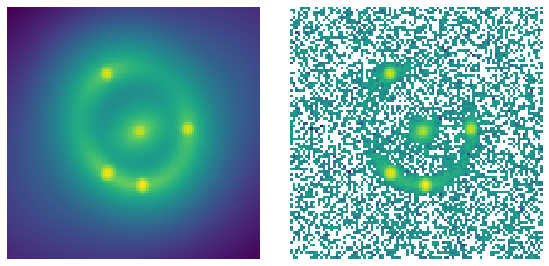

In [12]:
# Podemos agregar otras caracteristicas como:

import lenstronomy.Util.image_util as image_util

exp_time = 100  # tiempo de exposicion para cuantificar poisson noise 
background_rms = 0.1  # valor del rms del background
poisson = image_util.add_poisson(image, exp_time=exp_time)
bkg = image_util.add_background(image, sigma_bkd=background_rms)
image_noisy = image + bkg + poisson

f, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=False, sharey=False)
axes[0].matshow(np.log10(image), origin='lower')
axes[1].matshow(np.log10(image_noisy), origin='lower')
f.tight_layout()
axes[0].axis('off')
axes[1].axis('off')
plt.show()

## Ejercicio

Simular el sistema que utilizaron para los ejercicios de las clases 3 y 4. 
Guardar la simulacion como una imagen fits, con la informacion que consideren necesaria en el header, x ej. tiempo de exposicion, deltapix... 

In [13]:
#Modelo de la clase anterior
import lenstronomy.Util.param_util as param_util
from astropy.io import fits
e1,e2 = param_util.phi_q2_ellipticity(gradtorad(73),0.5)#complete phi(en radianes), q
x1,x2=-1.44,1.71#complete
theta_E=1.9#complete
lens_model_list = ['SIE'] #
lensModel = LensModel(lens_model_list=lens_model_list)
kwargs_sie = {'theta_E': theta_E, 'e1':e1 ,'e2':e2,'center_x': x1, 'center_y': x2}
kwargs_lens = [kwargs_sie]
deltaPix = 0.05
exp_time = 1000  # tiempo de exposicion para cuantificar poisson noise 
background_rms = 1.0  # valor del rms del background
supersampling_factor=1

In [14]:
# importamos la clase LightModel #
from lenstronomy.LightModel.light_model import LightModel

# preparamos la lista de perfiles luminosos a usar
source_light_model_list = ['SERSIC']
lightModel_source = LightModel(light_model_list=source_light_model_list)

lens_light_model_list = ['SERSIC_ELLIPSE']
lightModel_lens = LightModel(light_model_list=lens_light_model_list)


# definimos los parametros #
#amp es la amplitud al la mitad del radio de luz (half light radius)
#beta_ra = -0.95
#beta_dec = 1.6
beta_ra,beta_dec = -0.95,1.6
kwargs_light_source = [{'amp': 100, 'R_sersic': 0.1, 'n_sersic': 1.5, 'center_x': beta_ra, 'center_y': beta_dec}]

import lenstronomy.Util.param_util as param_util
e1, e2 = param_util.phi_q2_ellipticity(phi=0.5, q=0.7)
kwargs_light_lens = [{'amp': 1000, 'R_sersic': 0.1, 'n_sersic': 2.5, 'e1': e1, 'e2': e2, 'center_x': 0.1, 'center_y': 0}]

# Evalua el brillo superficial a una posicion especifica
flux = lightModel_lens.surface_brightness(x=1, y=1, kwargs_list=kwargs_light_lens)
flux

array(0.14634866)

In [15]:
# importamos la clase PointSource #
from lenstronomy.PointSource.point_source import PointSource

# utilizando la posicion de la fuente #
point_source_model_list = ['SOURCE_POSITION']
pointSource = PointSource(point_source_type_list=point_source_model_list, lensModel=lensModel, fixed_magnification_list=[True])
#Si fixed_magnification=True, entonces usa ‘source_amp’, osea la amplitud de la fuente
#sino usa 'point_amp' que es la magnificacion de cada imagen de la fuente

kwargs_ps = [{'ra_source': beta_ra, 'dec_source': beta_dec, 'source_amp': 100}]

# La posiciones de las imagenes y sus amplitudes  #
x_pos, y_pos = pointSource.image_position(kwargs_ps=kwargs_ps, kwargs_lens=kwargs_lens)
point_amp = pointSource.image_amplitude(kwargs_ps=kwargs_ps, kwargs_lens=kwargs_lens)


In [16]:
# import la clase PixelGrid()#
from lenstronomy.Data.pixel_grid import PixelGrid

#deltaPix = 0.05  # tamano del pixel en cordenadas angulares (arcsec)

# configurar los argumentos para crear la clase Data 
ra_at_xy_0, dec_at_xy_0 = -2.5, -2.5 # coordinate in angles (RA/DEC) at the position of the pixel edge (0,0)
transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix  # linear translation matrix of a shift in pixel in a shift in coordinates

kwargs_pixel = {'nx': 100, 'ny': 100,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 

pixel_grid = PixelGrid(**kwargs_pixel)

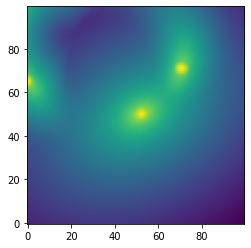

In [17]:
# importar la clase ImageModel
from lenstronomy.ImSim.image_model import ImageModel
# definimos "numerics" 
# una instancia que nos permitira realizar computos con distintas configuraciones
# Cada configuracion dependera de lo que se quiere lograr.
# y tendra implicaciones tanto en el tiempo de computo como en la presicion del modelo
# Para mas detalles pueden revisar el notebook "lenstronomy_numerics" en las extensiones de lenstronomy

kwargs_numerics = {'supersampling_factor': supersampling_factor, # each pixel gets super-sampled (in each axis direction) 
                  'supersampling_convolution': False}

# inicializar la clase ImageModel combinando los modulos que creamos antes 
imageModel = ImageModel(data_class=pixel_grid, 
                        psf_class=psf, 
                        lens_model_class=lensModel,
                        source_model_class=lightModel_source,
                        lens_light_model_class=lightModel_lens,
                        point_source_class= pointSource, 
                        kwargs_numerics=kwargs_numerics)


# simulamos la imagen con los paremetros definidos antes
image = imageModel.image(kwargs_lens=kwargs_lens,
                         kwargs_source=kwargs_light_source,
                         kwargs_lens_light=kwargs_light_lens, 
                         kwargs_ps=kwargs_ps)
plt.imshow(np.log10(image),origin='lower')

In [18]:
#Siempre en la misma linea 

<ipython-input-19-3de2e0a82a7c>:13: RuntimeWarning: invalid value encountered in log10
  axes[1].matshow(np.log10(image_noisy), origin='lower')


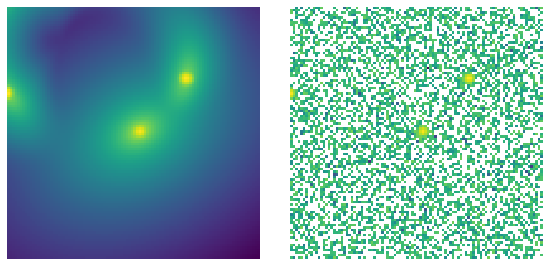

In [19]:
# Podemos agregar otras caracteristicas como:

import lenstronomy.Util.image_util as image_util

#exp_time = 100  # tiempo de exposicion para cuantificar poisson noise 
#background_rms = 0.1  # valor del rms del background
poisson = image_util.add_poisson(image, exp_time=exp_time)
bkg = image_util.add_background(image, sigma_bkd=background_rms)
image_noisy = image + bkg + poisson

f, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=False, sharey=False)
axes[0].matshow(np.log10(image), origin='lower')
axes[1].matshow(np.log10(image_noisy), origin='lower')
f.tight_layout()
axes[0].axis('off')
axes[1].axis('off')
plt.show()

In [20]:
nombre_fits='imagen1'
hdu = fits.PrimaryHDU(np.log10(image_noisy))
hdul = fits.HDUList([hdu])
hdul.writeto(nombre_fits+'.fits')

<ipython-input-20-4723b96d1819>:2: RuntimeWarning: invalid value encountered in log10
  hdu = fits.PrimaryHDU(np.log10(image_noisy))


OSError: File 'imagen1.fits' already exists.

In [39]:
nombre_fits='sistema_felipe'
hdul = fits.open(nombre_fits+'.fits')
hdr = hdul[0].header
#hdr['targname'] = (nombre_fits, 'the observation target')
#hdr['bg_rms']=(background_rms,"  rms del background")
#hdr['exp_time']=(exp_time,"tiempo de exposicion ")
#hdr['deltaPix']=(deltaPix,"tam pix en cord ang (arcsec)") 
hdul[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100                                                  
NAXIS2  =                  100                                                  
DELTAPIX=                 0.06                                                  
NUMPIX  =                  100                                                  
FWHM_PSF=                  0.2                                                  
NAMEOBJ = 'sistema_Felipe_a'                                                    
EXP_TIME=                 1000                                                  

In [35]:
data = hdul[0].data
data.shape

(50, 50)

<ipython-input-37-0af7707bed67>:1: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(data))


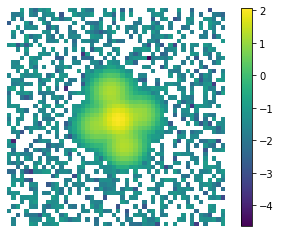

In [37]:
plt.imshow(np.log10(data))
#plt.imshow(data)
plt.axis('off')
plt.colorbar()